# ETA Prediction with AIS data

## Loading Data

In [198]:
# Importing the required libraries and scripts

import os
import sys
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shutil
from scipy import stats
from sklearn import metrics
from datetime import timedelta
sns.set()
from subprocess import check_output
import folium as fl
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from shapely.geometry import Point
import geopandas.tools
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
from math import radians, sin, cos, sqrt, atan2
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

os.chdir("D:\\A TESE\\Modelo ML")
scripts_dir = r"D:\A TESE\Modelo ML\Scripts"
sys.path.append(scripts_dir)
import unzip_to_csv as unzip
import Scripts.splitted_csv as voyages_split


In [266]:
# Defining paths to the base directory and checking

Raw_Data = "D:\\A TESE\\Modelo ML\\Raw_Data"
unzipped = "D:\\A TESE\\Modelo ML\\unzipped"
APS_Dataset = "D:\\A TESE\\Modelo ML\\CSV\\merged_dataset.csv"
Fil_Data = "D:\\A TESE\\Modelo ML\\CSV\\filtered_dataset.csv"
Clean_Data = "D:\\A TESE\\Modelo ML\\CSV\\cleaned_dataset.csv"
Final_Dataset = "D:\A TESE\Modelo ML\CSV\final_dataset.csv"

Voyages_un = "D:\\A TESE\\Modelo ML\\CSV\\voyages_splitted"
Voyages_reach = "D:\\A TESE\\Modelo ML\\CSV\\voyages_reached"
Voyages_out = "D:\\A TESE\\Modelo ML\\CSV\\voyages_out"
Voyages_excl = "D:\\A TESE\\Modelo ML\\CSV\\voyages_outliers"
Voyages_final = "D:\\A TESE\\Modelo ML\\CSV\\voyages_final"

Plots = "D:\\A TESE\\Modelo ML\\Plots\\finished_voyages"
Outliers = "D:\\A TESE\\Modelo ML\\Plots\\Outliers"
Voyages_unfin = "D:\\A TESE\\Modelo ML\\Plots\\unfinished_voyages"

Map_html = "D:\\A TESE\\Modelo ML\\Sines_map.html"
Html_folder = "D:\\A TESE\\Modelo ML\\HTML\\"

print(Raw_Data)
print(unzipped)
print(APS_Dataset)
print(Fil_Data)
print(Clean_Data)
print(Final_Dataset)

print(Voyages_un)
print(Voyages_reach)
print (Voyages_excl)
print (Voyages_final)

print(Plots)
print (Outliers)
print (Voyages_out)

print(Map_html)
print(Html_folder)


D:\A TESE\Modelo ML\Raw_Data
D:\A TESE\Modelo ML\unzipped
D:\A TESE\Modelo ML\CSV\merged_dataset.csv
D:\A TESE\Modelo ML\CSV\filtered_dataset.csv
D:\A TESE\Modelo ML\CSV\cleaned_dataset.csv
D:\A TESE\Modelo ML\CSVinal_dataset.csv
D:\A TESE\Modelo ML\CSV\voyages_splitted
D:\A TESE\Modelo ML\CSV\voyages_reached
D:\A TESE\Modelo ML\CSV\voyages_outliers
D:\A TESE\Modelo ML\CSV\voyages_final
D:\A TESE\Modelo ML\Plots\finished_voyages
D:\A TESE\Modelo ML\Plots\Outliers
D:\A TESE\Modelo ML\CSV\voyages_out
D:\A TESE\Modelo ML\Sines_map.html
D:\A TESE\Modelo ML\HTML\


In [ ]:
# Unzipping files and saving it into a single CSV
# using a created script named unzip_to_csv.py

unzip.main(Raw_Data,unzipped,APS_Dataset)


In [ ]:
# Loading the dataset
# The dataset is to large => use of chunksize
# It allows to load a portion of the file into memory, process it, and then discard that chunk to load the next one
# Due to hardware constraints, we need to save automatically to a new CSV because the space allocated to C: have no space for df
# At the same time changes were made to make new dataset lighter
# Unnecessary columns were dropped.
# Only ships with code 70 have been saved or nulls (in case a 70 code ship has a null in some lines).


# Defining chunk size for memory-efficient reading to 100.000 lines each chunk
chunk_size = 100000

#Defining the columns to drop
columns_to_drop = ['SourceName', 'Name', 'tipo_desc', 'calado', 'largura', 'comprimento', 'Simulated']

# Initializing an empty list to store the processed chunks
chunks = []

# Iterating through each chunk
for chunk in pd.read_csv(APS_Dataset, chunksize=chunk_size):
    
    # Step 1: Dropping unnecessary columns
    chunk = chunk.drop(columns=columns_to_drop, errors='ignore')
    
    # Step 2: Filtering rows where tipo_cod is 70 or tipo_cod is null (NaN)
    filtered_chunk = chunk[(chunk['tipo_cod'] == 70) | (chunk['tipo_cod'].isnull())]
    
    # Step 3: Writing filtered data to the output CSV in append mode
    filtered_chunk.to_csv(Fil_Data_0, mode='a', header=not os.path.exists(Fil_Data), index=False)

print(f"Filtered data has been saved to {Fil_Data_0}")    

In [5]:
# Dataset with data without unnecessary columns and only ships of type 70 or with null values

dataset = pd.read_csv('D:\\A TESE\\Modelo ML\\CSV\\filtered_dataset_0.csv')

## First look

In [7]:
dataset.shape

(71763789, 10)

In [9]:
dataset.dtypes

UTCDate         object
long           float64
lat            float64
MMSI             int64
Imo            float64
tipo_cod         int64
ETA             object
Destination     object
SOGKnots       float64
COGDegrees     float64
dtype: object

In [11]:
dataset.head(5)

,UTCDate,long,lat,MMSI,Imo,tipo_cod,ETA,Destination,SOGKnots,COGDegrees
0,2023-07-12 06:06:46,-9.572355,37.723582,356413000,9856282.0,70,2023-07-14 06:00:00,ES GIJ,12.8,347.4
1,2023-07-12 06:06:46,-7.583417,36.053613,636017197,9696450.0,70,2023-07-12 15:00:00,ES ALG,12.6,98.3
2,2023-07-12 06:06:47,-9.675808,37.227897,566675000,9613422.0,70,2023-07-17 06:00:00,MARTAS,12.6,170.1
3,2023-07-12 06:06:49,-6.707450,36.073435,440371000,9158616.0,70,2023-07-13 00:01:00,PTSET,13.1,288.5
4,2023-07-12 06:06:51,-9.161438,37.942635,355835000,9709336.0,70,2023-07-16 07:00:00,SLUISKIL,11.5,299.9


In [13]:
null_summary = dataset.isnull().sum()
print(null_summary)

UTCDate            0
long            4544
lat             4544
MMSI               0
Imo             2261
tipo_cod           0
ETA            71176
Destination    51923
SOGKnots        4841
COGDegrees     29600
dtype: int64


## Data Handling

In [15]:
dfToClean = dataset

In [17]:
dfToClean.shape

(71763789, 10)

In [19]:
dfToClean.dtypes

UTCDate         object
long           float64
lat            float64
MMSI             int64
Imo            float64
tipo_cod         int64
ETA             object
Destination     object
SOGKnots       float64
COGDegrees     float64
dtype: object

### Types

In [21]:
# Converting the 'ETA' and 'UTCDate' columns (which are an object) to datetime
dfToClean['ETA'] = pd.to_datetime(dfToClean['ETA'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
dfToClean['UTCDate'] = pd.to_datetime(dfToClean['UTCDate'], format='%Y-%m-%d %H:%M:%S', errors='coerce')


In [23]:
dfToClean.dtypes

UTCDate        datetime64[ns]
long                  float64
lat                   float64
MMSI                    int64
Imo                   float64
tipo_cod                int64
ETA            datetime64[ns]
Destination            object
SOGKnots              float64
COGDegrees            float64
dtype: object

### Standardization of 'Destination' feature

In [25]:
# List of valid destinations and replacing all by PTSines
destinations = [
    'SINES', 'ANTWERP>>>SINES', '44SINES', 'FOR ORDER SINES ANCH', 'HALIFAX SINES', 'MAPTM>SINES',
    'OPLSINES', 'PORTO_SINES', 'PT SIE  SINES', 'PT SINES', 'PTSIE SINES', 'PTSIE-SINES',
    'PTSINES', 'SINES  FOR ORDERS', 'SINES  PORTUGAL', 'SINES (PTSIE)', 'SINES - B3',
    'SINES - BERTH 5', 'SINES - PILOT STN', 'SINES ANCHORAGE', 'SINES OPL', 'SINES PORTUGAL',
    'SINES PT', 'SINES PTSIE', 'SINES(PORTUGAL)', 'SINES,', 'SINES, PORTUGAL', 'SINES, PT',
    'SINES,PORTUGAL', 'SINES,PRTGL', 'SINES-PORTUGAL', 'SINES-PT', 'SINES. PORTUGAL',
    'SINES.PORTUGAL', 'SINES_PT'
]

# Filtering ships with valid destinations or null destinations
dfToClean = dataset[dataset['Destination'].isin(destinations) | dataset['Destination'].isnull()]

# Replacing all valid destinations in the list with 'PTSines'
dfToClean['Destination'] = dfToClean['Destination'].replace(destinations, 'PTSines')

dfToClean.shape

(847821, 10)

### Renaming features

In [27]:
# Defining the new column mapping
# aligned with AIS international standards 
dfToClean = dfToClean.rename(columns={
    'UTCDate': 'BaseDateTime',
    'long': 'LON',
    'lat': 'LAT',
    'tipo_cod': 'Type', 
    'SOGKnots': 'SOG', 
    'COGDegrees': 'COG',
})

### Grouping data by 'ShipVoyage' and selecting voyages that reached the port

In [29]:
# Separating our data in ShipVoyage, which is all records of a voyage


# Defining the Sines port coordinates (Latitude, Longitude)
SINES_COORDS = [37.933896, -8.855063]
RADIUS_THRESHOLD_KM = 7  # 7 km radius

# Step 1: Sorting the DataFrame by MMSI and BaseDateTime
dfToClean = dfToClean.sort_values(by=['MMSI', 'BaseDateTime'])

# Step 2: Creating the ShipVoyage column based on the 6-hour gap
# Initializing a column for ShipVoyage
dfToClean['ShipVoyage'] = None

# Initializing an empty dictionary to track voyage numbers for each MMSI
voyage_counter = {}

# Iterating through the rows to assign ShipVoyage
last_mmsi = None
last_time = None

for idx, row in dfToClean.iterrows():
    mmsi = row['MMSI']
    current_time = pd.to_datetime(row['BaseDateTime'])
    
    # Initializing voyage number if new MMSI
    if mmsi != last_mmsi:
        voyage_counter[mmsi] = 0  # Start voyage count at 0 for each MMSI
        dfToClean.at[idx, 'ShipVoyage'] = f"{mmsi}_0"  # First voyage starts at _0
    else:
        # Checking if the time difference is greater than 6 hours to start a new voyage
        if (current_time - last_time).total_seconds() > 6 * 3600:
            voyage_counter[mmsi] += 1  # Increment the voyage number
        dfToClean.at[idx, 'ShipVoyage'] = f"{mmsi}_{voyage_counter[mmsi]}"  # Assign voyage ID
    
    # Updating last_mmsi and last_time
    last_mmsi = mmsi
    last_time = current_time

# Step 3: Calculating the distance to Sines Port using the Haversine function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = np.sin(dlat / 2.0)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c  # Return distance in kilometers

# Step 4: Calculate the RTD (Remaining Distance to Destination) for each row in dfToClean
dfToClean['RTD'] = dfToClean.apply(
    lambda row: haversine(row['LAT'], row['LON'], SINES_COORDS[0], SINES_COORDS[1]), axis=1
)

# Step 5: Updating each voyage to remove rows after the first time RTD < 7 km
def update_voyage(group):
    # Find the first index where RTD is less than or equal to 7 km
    first_within_7km = group[group['RTD'] <= RADIUS_THRESHOLD_KM].index.min()

    # If such a row is found, keep only the rows before or up to this index
    if pd.notna(first_within_7km):
        return group.loc[:first_within_7km]
    return group  # If no row is within 7 km, keep the full group

# Apply the update function to each ShipVoyage group
dfToClean = dfToClean.groupby('ShipVoyage').apply(update_voyage).reset_index(drop=True)

# Step 6: Initializing dfCheck to store voyages with PTSines destination passing within the 7 km radius
dfCheck = pd.DataFrame()

# Filter voyages where destination is PTSines and the ship passes within 7 km
def filter_voyages(group):
    if 'PTSines' in group['Destination'].values:
        within_7km = group[group['RTD'] <= RADIUS_THRESHOLD_KM]
        if not within_7km.empty:
            return group  # Add to dfCheck if any part of the voyage is within 7 km
    return pd.DataFrame()  # Return empty dataframe if condition isn't met

# Apply filtering to each ShipVoyage
dfCheck = dfToClean.groupby('ShipVoyage').apply(filter_voyages).reset_index(drop=True)

# Step 7: Remove 'RTD' column if you don't need it anymore
dfToClean = dfToClean.drop(columns=['RTD'])

# Step 8: Print out results for confirmation
print(dfCheck[['MMSI', 'Destination', 'BaseDateTime', 'ShipVoyage']].head())

dfCheck.to_csv(Fil_Data, index=False)

          MMSI Destination        BaseDateTime   ShipVoyage
0  209550000.0     PTSines 2023-09-25 12:49:00  209550000_0
1  209550000.0     PTSines 2023-09-25 12:49:02  209550000_0
2  209550000.0     PTSines 2023-09-25 12:49:14  209550000_0
3  209550000.0     PTSines 2023-09-25 12:49:14  209550000_0
4  209550000.0     PTSines 2023-09-25 12:49:20  209550000_0


In [33]:
dfCheck.head()

,BaseDateTime,LON,LAT,MMSI,Imo,Type,ETA,Destination,SOG,COG,ShipVoyage,RTD
0,2023-09-25 12:49:00,-7.689917,36.357050,209550000.0,9285990.0,70.0,2023-09-25 15:00:00,PTSines,16.8,288.0,209550000_0,203.485182
1,2023-09-25 12:49:02,-7.690650,36.357233,209550000.0,9285990.0,70.0,2023-09-25 15:00:00,PTSines,16.8,288.0,209550000_0,203.434578
2,2023-09-25 12:49:14,-7.691667,36.357500,209550000.0,9285990.0,70.0,2023-09-25 15:00:00,PTSines,16.8,288.0,209550000_0,203.363237
3,2023-09-25 12:49:14,-7.691667,36.357500,209550000.0,9285990.0,70.0,2023-09-25 15:00:00,PTSines,16.8,288.0,209550000_0,203.363237
4,2023-09-25 12:49:20,-7.692200,36.357650,209550000.0,9285990.0,70.0,2023-09-25 15:00:00,PTSines,16.8,288.0,209550000_0,203.324848


In [35]:
# Checking the number of unique ShipVoyage values
unique_shipvoyages = dfCheck['ShipVoyage'].nunique()

print(f"Number of unique ShipVoyage values: {unique_shipvoyages}")

Number of unique ShipVoyage values: 91


### Missing values

In [37]:
null_summary = dfCheck.isnull().sum()
print(null_summary)

BaseDateTime     0
LON              1
LAT              1
MMSI             0
Imo             29
Type             0
ETA             29
Destination     29
SOG              1
COG              1
ShipVoyage       0
RTD              1
dtype: int64


In [39]:
# Filling null values at IMO  identification and Destination (PTSines)
dfCheck['Destination'].fillna('PTSines', inplace=True)

# Group by 'ShipVoyage', then propagate non-null IMO values forward and backward
dfCheck['Imo'] = dfCheck.groupby('ShipVoyage')['Imo'].transform(lambda group: group.ffill().bfill())

null_summary = dfCheck.isnull().sum()
print(null_summary)

BaseDateTime     0
LON              1
LAT              1
MMSI             0
Imo              0
Type             0
ETA             29
Destination      0
SOG              1
COG              1
ShipVoyage       0
RTD              1
dtype: int64


In [41]:
# Filling missing ETAs with the median of the ETA before and after within the same voyage
def fill_missing_eta(group):
    # Use forward and backward fill first to ensure values at the edges (beginning and end) are handled
    group['ETA'] = group['ETA'].fillna(method='ffill').fillna(method='bfill')
    
    # Calculating the median for gaps within the group
    # If the current ETA is still null
    # Take the ETA before and after the current one
    for i in range(1, len(group)-1):
        if pd.isnull(group['ETA'].iloc[i]):  
            
            prev_eta = group['ETA'].iloc[i-1]
            next_eta = group['ETA'].iloc[i+1]
            
            # Only fill if both previous and next ETAs are valid (not NaT)
            if pd.notnull(prev_eta) and pd.notnull(next_eta):
                # Fill with the median between the previous and next ETA
                group['ETA'].iloc[i] = prev_eta + (next_eta - prev_eta) / 2
            
    return group

# Groupping by ShipVoyage and filling missing ETAs
dfCheck = dfCheck.groupby('ShipVoyage').apply(fill_missing_eta)

null_summary = dfCheck.isnull().sum()
print(null_summary)

BaseDateTime    0
LON             1
LAT             1
MMSI            0
Imo             0
Type            0
ETA             0
Destination     0
SOG             1
COG             1
ShipVoyage      0
RTD             1
dtype: int64


In [49]:
# Filtering the dataset to show rows where any column has null values
rows_with_nulls = dfCheck[dfCheck.isnull().any(axis=1)]

print(rows_with_nulls)

                          BaseDateTime  LON  LAT         MMSI        Imo  \
ShipVoyage                                                                 
353289000_0 194183 2024-05-13 09:41:29  NaN  NaN  353289000.0  9372482.0   

                    Type                 ETA Destination  SOG  COG  \
ShipVoyage                                                           
353289000_0 194183  70.0 2024-09-23 20:59:00     PTSines  NaN  NaN   

                     ShipVoyage  RTD  
ShipVoyage                            
353289000_0 194183  353289000_0  NaN  


In [57]:
# Dropping any row that contains null values
dfCheck = dfCheck.dropna()

null_summary = dfCheck.isnull().sum()
print(null_summary)

BaseDateTime    0
LON             0
LAT             0
MMSI            0
Imo             0
Type            0
ETA             0
Destination     0
SOG             0
COG             0
ShipVoyage      0
RTD             0
dtype: int64


In [59]:
dfCheck.shape

(438012, 12)

### Duplicates

In [61]:
# Dropping duplicate rows where 'ShipVoyage', 'BaseDateTime', 'lON', and 'lAT' are the same
dfCheck = dfCheck.drop_duplicates(subset=['ShipVoyage', 'BaseDateTime', 'LON', 'LAT'], keep='first')

dfCheck.shape

(381529, 12)

In [63]:
# Counting the number of unique voyages based on 'ShipVoyage'
unique_voyages = dfCheck['ShipVoyage'].nunique()

print(f"Number of unique voyages: {unique_voyages}")

Number of unique voyages: 91


In [65]:
dfCheck.head(3)

BaseDateTime       LON        LAT         MMSI  \
ShipVoyage                                                            
209550000_0 0 2023-09-25 12:49:00 -7.689917  36.357050  209550000.0   
            1 2023-09-25 12:49:02 -7.690650  36.357233  209550000.0   
            2 2023-09-25 12:49:14 -7.691667  36.357500  209550000.0   

                     Imo  Type                 ETA Destination   SOG    COG  \
ShipVoyage                                                                    
209550000_0 0  9285990.0  70.0 2023-09-25 15:00:00     PTSines  16.8  288.0   
            1  9285990.0  70.0 2023-09-25 15:00:00     PTSines  16.8  288.0   
            2  9285990.0  70.0 2023-09-25 15:00:00     PTSines  16.8  288.0   

                ShipVoyage         RTD  
ShipVoyage                              
209550000_0 0  209550000_0  203.485182  
            1  209550000_0  203.434578  
            2  209550000_0  203.363237

In [67]:
# Saving to the csv
dfCheck.to_csv(Clean_Data, index=False)

## Selecting voyages

In [69]:
# Splitting our Clean_Data into separated csv in order of 'ShipVoyage' feature
voyages_split.main(Clean_Data,Voyages_un)

Saved D:\A TESE\Modelo ML\CSV\voyages_splitted\ShipVoyage_209550000_0.csv
Saved D:\A TESE\Modelo ML\CSV\voyages_splitted\ShipVoyage_209720000_0.csv
Saved D:\A TESE\Modelo ML\CSV\voyages_splitted\ShipVoyage_209917000_0.csv
Saved D:\A TESE\Modelo ML\CSV\voyages_splitted\ShipVoyage_236111906_1.csv
Saved D:\A TESE\Modelo ML\CSV\voyages_splitted\ShipVoyage_236111906_2.csv
Saved D:\A TESE\Modelo ML\CSV\voyages_splitted\ShipVoyage_236111906_3.csv
Saved D:\A TESE\Modelo ML\CSV\voyages_splitted\ShipVoyage_236111906_4.csv
Saved D:\A TESE\Modelo ML\CSV\voyages_splitted\ShipVoyage_236111906_6.csv
Saved D:\A TESE\Modelo ML\CSV\voyages_splitted\ShipVoyage_236111906_7.csv
Saved D:\A TESE\Modelo ML\CSV\voyages_splitted\ShipVoyage_236111906_8.csv
Saved D:\A TESE\Modelo ML\CSV\voyages_splitted\ShipVoyage_244129000_0.csv
Saved D:\A TESE\Modelo ML\CSV\voyages_splitted\ShipVoyage_244129000_1.csv
Saved D:\A TESE\Modelo ML\CSV\voyages_splitted\ShipVoyage_244379000_0.csv
Saved D:\A TESE\Modelo ML\CSV\voyages_

'Total voyages split into separate CSV files: None'

In [71]:
# # Counting the number of CSV files
csv_files = [f for f in os.listdir(Voyages_un) if f.endswith('.csv')]
csv_count = len(csv_files)

print(f"Total CSV files created: {csv_count}")

Total CSV files created: 91


### Plotting finished and unfinished voyages

In [79]:
# Defining the Sines port coordinates (Latitude, Longitude)
SINES_COORDS = [37.933896, -8.855063]
RADIUS_THRESHOLD_KM_OUT = 57  # 57km radius threshold from SINES_COORDS, or 50km from 7km radius

# Haversine function to calculate the distance between two lat/lon points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1_rad, lon1_rad = radians(lat1), radians(lon1)
    lat2_rad, lon2_rad = radians(lat2), radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = sin(dlat / 2.0)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2.0)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c  # Return distance in kilometers

# Checking and saving valid voyages, plotting them, and keeping their files
def check_and_save_voyages(voyages_un_folder, voyages_reached_folder, voyages_out_folder, voyages_unfin_folder, plot_folder):
    # Ensure the output folders exist
    os.makedirs(voyages_reached_folder, exist_ok=True)
    os.makedirs(voyages_out_folder, exist_ok=True)
    os.makedirs(voyages_unfin_folder, exist_ok=True)
    os.makedirs(plot_folder, exist_ok=True)

    # Loading the world map to use in plots
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    europe = world[world['continent'] == 'Europe']

    for file in os.listdir(voyages_un_folder):
        if file.endswith('.csv'):
            file_path = os.path.join(voyages_un_folder, file)
            voyage_df = pd.read_csv(file_path)

            # Calculate RTD (Remaining Distance to Destination) for each point in the voyage
            voyage_df['Distance_to_Sines_km'] = voyage_df.apply(
                lambda row: haversine(row['LAT'], row['LON'], SINES_COORDS[0], SINES_COORDS[1]), axis=1
            )

            # Check if any part of the voyage started OUTSIDE the 57 km radius
            if (voyage_df['Distance_to_Sines_km'] > RADIUS_THRESHOLD_KM_OUT).any():
                # Keep the voyage if there is any part outside the 57 km radius
                destination_path = os.path.join(voyages_reached_folder, file)
                voyage_df.to_csv(destination_path, index=False)
                
                # Plotting kept voyages and saving to Plot folder
                plot_voyage(voyage_df, file, plot_folder, europe)
            else:
                # Save and plot voyages that do not meet the criteria
                out_destination = os.path.join(voyages_out_folder, file)
                voyage_df.to_csv(out_destination, index=False)
                plot_voyage(voyage_df, file, voyages_unfin_folder, europe)

# Plotting voyages and saving the plots with better zoom and circular legend
def plot_voyage(voyage_df, file_name, output_folder, europe):
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    europe.plot(ax=ax, color='lightgrey', edgecolor='black')
    plt.plot(voyage_df['LON'], voyage_df['LAT'], marker='o', color='blue', label='Voyage Path', alpha=0.7)
    
    # Highlighting start and end points
    plt.scatter(voyage_df['LON'].iloc[0], voyage_df['LAT'].iloc[0], color='green', label='Start', s=100)
    plt.scatter(voyage_df['LON'].iloc[-1], voyage_df['LAT'].iloc[-1], color='red', label='End', s=100)

    # Sines port and radius
    plt.scatter(SINES_COORDS[1], SINES_COORDS[0], color='black', label='Sines Port', s=200, marker='x')
    
    # Plotting 7 km and 50 km radius circles
    circle_7km = plt.Circle((SINES_COORDS[1], SINES_COORDS[0]), 0.063, color='r', fill=False, label='7 km Radius')
    circle_50km = plt.Circle((SINES_COORDS[1], SINES_COORDS[0]), 0.45, color='b', fill=False, label='50 km Radius')
    ax.add_patch(circle_7km)
    ax.add_patch(circle_50km)

    # Adjusting limits to ensure we zoom correctly around the voyage path and port
    lon_min, lon_max = min(voyage_df['LON'].min(), SINES_COORDS[1] - 0.2), max(voyage_df['LON'].max(), SINES_COORDS[1] + 0.2)
    lat_min, lat_max = min(voyage_df['LAT'].min(), SINES_COORDS[0] - 0.2), max(voyage_df['LAT'].max(), SINES_COORDS[0] + 0.2)
    plt.xlim(lon_min, lon_max)
    plt.ylim(lat_min, lat_max)

    # Customizing the legend with circular markers
    circle_legend_elements = [
        Line2D([0], [0], color='r', marker='o', markersize=10, label='7 km Radius', linestyle='None'),
        Line2D([0], [0], color='b', marker='o', markersize=10, label='50 km Radius', linestyle='None')
    ]
    
    plt.title(f'Voyage Plot: {file_name}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Adding the custom legend with circular markers
    plt.legend(handles=circle_legend_elements, loc='upper right')

    # Saving the plot
    output_path = os.path.join(output_folder, file_name.replace('.csv', '.png'))
    plt.savefig(output_path)
    plt.close()

    print(f"Saved plot for {file_name} to {output_path}")

# Calling the function to check, save, and plot voyages
check_and_save_voyages(Voyages_un, Voyages_reach, Voyages_out, Voyages_unfin, Plots)


Saved plot for ShipVoyage_209550000_0.csv to D:\A TESE\Modelo ML\Plots\finished_voyages\ShipVoyage_209550000_0.png
Saved plot for ShipVoyage_209720000_0.csv to D:\A TESE\Modelo ML\Plots\finished_voyages\ShipVoyage_209720000_0.png
Saved plot for ShipVoyage_209917000_0.csv to D:\A TESE\Modelo ML\Plots\finished_voyages\ShipVoyage_209917000_0.png
Saved plot for ShipVoyage_236111906_1.csv to D:\A TESE\Modelo ML\Plots\finished_voyages\ShipVoyage_236111906_1.png
Saved plot for ShipVoyage_236111906_2.csv to D:\A TESE\Modelo ML\Plots\unfinished_voyages\ShipVoyage_236111906_2.png
Saved plot for ShipVoyage_236111906_3.csv to D:\A TESE\Modelo ML\Plots\finished_voyages\ShipVoyage_236111906_3.png
Saved plot for ShipVoyage_236111906_4.csv to D:\A TESE\Modelo ML\Plots\finished_voyages\ShipVoyage_236111906_4.png
Saved plot for ShipVoyage_236111906_6.csv to D:\A TESE\Modelo ML\Plots\finished_voyages\ShipVoyage_236111906_6.png
Saved plot for ShipVoyage_236111906_7.csv to D:\A TESE\Modelo ML\Plots\finishe

In [81]:
# Verifying the number of CSV files
csv_files = [f for f in os.listdir(Voyages_reach) if f.endswith('.csv')]
csv_count = len(csv_files)

print(f"Total CSV files created: {csv_count}")

Total CSV files created: 80


In [83]:
# ShipVoyage_370271000_1 have a strange and unique behaviour
# It is not desirable that it counts for the model

file_name = "ShipVoyage_370271000_1.csv"

# Construct the full file paths
source_file_path = os.path.join(Voyages_reach, file_name)
destination_file_path = os.path.join(Voyages_out, file_name)

# Move the file if it exists
if os.path.exists(source_file_path):
    shutil.move(source_file_path, destination_file_path)
    print(f"File '{file_name}' moved to {Voyages_out}")
else:
    print(f"File '{file_name}' not found in {Voyages_reach}")

File 'ShipVoyage_370271000_1.csv' moved to D:\A TESE\Modelo ML\CSV\voyages_out


In [85]:
# Verifying the number of CSV files
csv_files = [f for f in os.listdir(Voyages_reach) if f.endswith('.csv')]
csv_count = len(csv_files)

print(f"Total CSV files created: {csv_count}")

Total CSV files created: 79


### Creating RTT column

In [107]:
# Processing each CSV file and calculating RTT (Remaining Travel Time)
def process_voyage(file_path):
    voyage_df = pd.read_csv(file_path)

    # Ensuring that 'BaseDateTime' and 'ETA' is in datetime format
    voyage_df['BaseDateTime'] = pd.to_datetime(voyage_df['BaseDateTime'], errors='coerce')
    voyage_df['ETA'] = pd.to_datetime(voyage_df['ETA'], errors='coerce')

    # Calculating RTT using RTD and SOG (treat SOG=0 as SOG=1)
    # SOG is in knots; 1 knot = 1.852 kilometers/hour
    voyage_df['RTT'] = voyage_df.apply(
        lambda row: row['RTD'] / (max(row['SOG'], 1) * 1.852) if pd.notna(row['RTD']) else np.nan, axis=1
    )

    # Dropping the 'Distance_to_Sines_km' column if it exists
    if 'Distance_to_Sines_km' in voyage_df.columns:
        voyage_df = voyage_df.drop(columns=['Distance_to_Sines_km'])

    return voyage_df

# Directory containing the voyage CSV files
Voyages_reach = "D:\\A TESE\\Modelo ML\\CSV\\voyages_reached"  # Update to your folder path if needed

# Loop through all the CSV files and process each voyage
for file in os.listdir(Voyages_reach):
    if file.endswith('.csv'):
        file_path = os.path.join(Voyages_reach, file)
        voyage_df = process_voyage(file_path)
        
        # Save the processed voyage back to the same file
        voyage_df.to_csv(file_path, index=False)
        
print("All voyages have been processed and updated.")


All voyages have been processed and updated.


In [109]:
merged_df = pd.DataFrame()

# Loop through all CSV files in the folder and concatenate them into one DataFrame
for file in os.listdir(Voyages_reach):
    if file.endswith('.csv'):
        file_path = os.path.join(Voyages_reach, file)
        voyage_df = pd.read_csv(file_path)
        merged_df = pd.concat([merged_df, voyage_df], ignore_index=True)

In [91]:
merged_df.shape

(362586, 14)

In [111]:
merged_df.head()

,BaseDateTime,LON,LAT,MMSI,Imo,Type,ETA,Destination,SOG,COG,ShipVoyage,RTD,RTT
0,2023-09-25 12:49:00,-7.689917,36.357050,209550000.0,9285990.0,70.0,2023-09-25 15:00:00,PTSines,16.8,288.0,209550000_0,203.485182,6.540072
1,2023-09-25 12:49:02,-7.690650,36.357233,209550000.0,9285990.0,70.0,2023-09-25 15:00:00,PTSines,16.8,288.0,209550000_0,203.434578,6.538445
2,2023-09-25 12:49:14,-7.691667,36.357500,209550000.0,9285990.0,70.0,2023-09-25 15:00:00,PTSines,16.8,288.0,209550000_0,203.363237,6.536153
3,2023-09-25 12:49:20,-7.692200,36.357650,209550000.0,9285990.0,70.0,2023-09-25 15:00:00,PTSines,16.8,288.0,209550000_0,203.324848,6.534919
4,2023-09-25 12:49:32,-7.693300,36.357950,209550000.0,9285990.0,70.0,2023-09-25 15:00:00,PTSines,16.8,288.0,209550000_0,203.246588,6.532403


In [113]:
null_summary = merged_df.isnull().sum()
print(null_summary)

BaseDateTime    0
LON             0
LAT             0
MMSI            0
Imo             0
Type            0
ETA             0
Destination     0
SOG             0
COG             0
ShipVoyage      0
RTD             0
RTT             0
dtype: int64


## Outliers

In [135]:
# Ensuring that 'BaseDateTime'and 'ETA' are in datetime format
merged_df['BaseDateTime'] = pd.to_datetime(merged_df['BaseDateTime'], errors='coerce')
merged_df['ETA'] = pd.to_datetime(merged_df['ETA'], errors='coerce')

# Calculating the time difference between the first and last row for each voyage
def calculate_time_difference_voyage(voyage_df):
    """Calculate the time difference between the first and last rows of a voyage."""
    time_diff = voyage_df['BaseDateTime'].max() - voyage_df['BaseDateTime'].min()
    return time_diff

# Formating timedelta to days, hours, minutes, and seconds
def format_timedelta(td):
    """Format timedelta to days, hours, minutes, and seconds."""
    days = td.days
    seconds = td.seconds
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return f"{days} days, {hours} hours, {minutes} minutes, {seconds} seconds"

# Processing the voyages in merged_df based on 'ShipVoyage'
def process_merged_voyages(merged_df):
    """Process voyages in the merged dataframe and return top 6 and bottom 6 based on time difference."""
    time_differences = []
    
    # Group the voyages by 'ShipVoyage' and calculate the time difference
    for voyage_id, voyage_data in merged_df.groupby('ShipVoyage'):
        time_diff = calculate_time_difference_voyage(voyage_data)
        time_differences.append((voyage_id, time_diff))
    
    # Sorting voyages by time difference
    time_differences.sort(key=lambda x: x[1], reverse=True)
    
    # Displaying the top 6 longest voyages
    print("Top 6 longest voyages:")
    for voyage_id, time_diff in time_differences[:6]:
        print(f"{voyage_id}: {format_timedelta(time_diff)}")
    
    # Displaying the bottom 6 shortest voyages
    print("\nBottom 6 shortest voyages:")
    for voyage_id, time_diff in time_differences[-6:]:
        print(f"{voyage_id}: {format_timedelta(time_diff)}")
    
    # Calculating and displaying the median time difference
    median_diff = pd.Series([td.total_seconds() for _, td in time_differences]).median()
    median_diff_timedelta = pd.to_timedelta(median_diff, unit='s')
    print(f"\nMedian time difference: {format_timedelta(median_diff_timedelta)}")

    return time_differences

# Calculating average voyage duration in hours
def calculate_average_duration_hours(time_differences):
    """Calculate the average voyage duration in hours."""
    if len(time_differences) == 0:
        return 0
    
    total_duration_seconds = sum([td.total_seconds() for _, td in time_differences])
    average_duration_hours = (total_duration_seconds / len(time_differences)) / 3600
    
    return average_duration_hours

# Processing voyages from merged_df
time_differences = process_merged_voyages(merged_df)

# Calculating and displaying the average voyage duration in hours
average_duration_hours = calculate_average_duration_hours(time_differences)
print(f"\nAverage voyage duration: {average_duration_hours:.2f} hours")

Top 6 longest voyages:
236111906_4: 1 days, 21 hours, 58 minutes, 58 seconds
236111906_6: 1 days, 20 hours, 32 minutes, 59 seconds
236111906_7: 1 days, 19 hours, 55 minutes, 45 seconds
255805867_0: 1 days, 15 hours, 17 minutes, 30 seconds
636022103_2: 1 days, 10 hours, 21 minutes, 38 seconds
255792000_0: 1 days, 9 hours, 13 minutes, 35 seconds

Bottom 6 shortest voyages:
246779000_0: 0 days, 4 hours, 4 minutes, 26 seconds
314638000_1: 0 days, 3 hours, 44 minutes, 10 seconds
255801770_0: 0 days, 3 hours, 43 minutes, 57 seconds
255915562_0: 0 days, 3 hours, 19 minutes, 49 seconds
246399000_0: 0 days, 2 hours, 47 minutes, 1 seconds
636020898_6: 0 days, 2 hours, 44 minutes, 54 seconds

Median time difference: 0 days, 12 hours, 1 minutes, 8 seconds

Average voyage duration: 14.59 hours


Outliers based on voyage durations:
                   Voyage_File  Duration_Hours
5   ShipVoyage_236111906_4.csv       45.982778
6   ShipVoyage_236111906_6.csv       44.549722
7   ShipVoyage_236111906_7.csv       43.929167
19  ShipVoyage_255792000_0.csv       33.226389
23  ShipVoyage_255805867_0.csv       39.291667
71  ShipVoyage_636022103_2.csv       34.360556


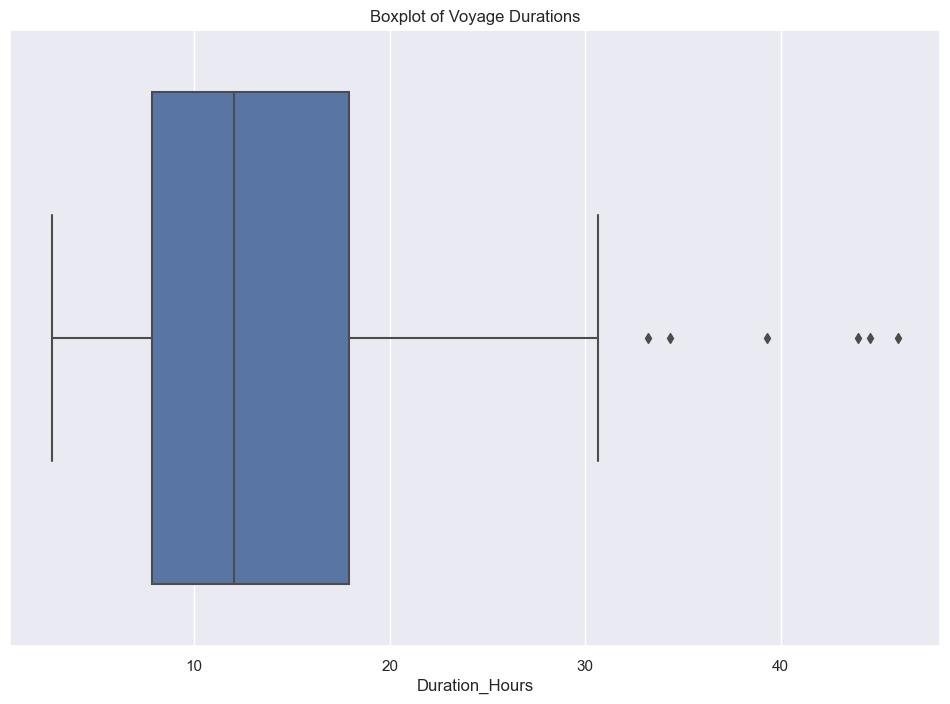

In [119]:
# Plotting the outliers
def calculate_time_difference(file_path):
    """Calculate the time difference between the first and last BaseDateTime in a voyage file."""
    voyage_df = pd.read_csv(file_path)
    voyage_df['BaseDateTime'] = pd.to_datetime(voyage_df['BaseDateTime'])
    first_time = voyage_df['BaseDateTime'].min()
    last_time = voyage_df['BaseDateTime'].max()
    return (last_time - first_time).total_seconds() / 3600  # Return difference in hours

def detect_outliers_iqr(time_differences):
    """Detect outliers using the IQR method."""
    Q1 = time_differences.quantile(0.25)
    Q3 = time_differences.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return time_differences[(time_differences < lower_bound) | (time_differences > upper_bound)]

# Folder with voyage CSV files
Voyages_reach = "D:\\A TESE\\Modelo ML\\CSV\\voyages_reached"

# List to store the voyage file name and time difference
voyage_differences = []

# Loop through all the CSV files in the folder
for file in os.listdir(Voyages_reach):
    if file.endswith('.csv'):
        file_path = os.path.join(Voyages_reach, file)
        time_diff_hours = calculate_time_difference(file_path)
        voyage_differences.append((file, time_diff_hours))

# Creating a DataFrame with the results
voyage_df = pd.DataFrame(voyage_differences, columns=['Voyage_File', 'Duration_Hours'])

# Detecting outliers using IQR
outliers = detect_outliers_iqr(voyage_df['Duration_Hours'])

# Printing the outliers
print("Outliers based on voyage durations:")
print(voyage_df[voyage_df['Duration_Hours'].isin(outliers)])

# Plotting the outliers (boxplot)
sns.boxplot(x=voyage_df['Duration_Hours'])
plt.title('Boxplot of Voyage Durations')
plt.show()

In [129]:
# Checking how many time the outliers spent in the area around the port
# Depending on this we keep or not

# Sines port coordinates (center of the circle)
Sines_coords = [37.933896, -8.855063]
radius_km = 57  # 57 km radius

# List of outlier voyages based on previous analysis
outlier_voyages = [
    '236111906_4', '236111906_6', '236111906_7', 
    '255792000_0', '255805867_0', '636022103_2'    
]

# Loop through the outlier voyages and calculate the time spent within the 50 km radius
for voyage_id in outlier_voyages:    
    voyage_df = merged_df[merged_df['ShipVoyage'] == voyage_id]
    
    voyage_df['Distance_to_Sines_km'] = voyage_df.apply(
        lambda row: haversine(row['LAT'], row['LON'], Sines_coords[0], Sines_coords[1]), axis=1
    )

    # Filtering the points within the 50 km radius
    within_radius_df = voyage_df[voyage_df['Distance_to_Sines_km'] <= radius_km]

    # Checking if there are any points within the 50 km radius
    if not within_radius_df.empty:        
        entry_timestamp = within_radius_df['BaseDateTime'].min()
        exit_timestamp = within_radius_df['BaseDateTime'].max()

        # Calculating the time difference between the first and last points within the radius
        duration_within_radius = exit_timestamp - entry_timestamp
       
        print(f"Voyage {voyage_id} entered the 50 km radius at: {entry_timestamp}")
        print(f"Voyage {voyage_id} exited the 50 km radius at: {exit_timestamp}")
        print(f"Voyage {voyage_id} stayed within 50 km radius for: {duration_within_radius}")
    else:
        print(f"Voyage {voyage_id} had no points within the 50 km radius.")

Voyage 236111906_4 entered the 50 km radius at: 2023-08-04 21:13:08
Voyage 236111906_4 exited the 50 km radius at: 2023-08-06 13:57:13
Voyage 236111906_4 stayed within 50 km radius for: 1 days 16:44:05
Voyage 236111906_6 entered the 50 km radius at: 2023-08-24 03:08:31
Voyage 236111906_6 exited the 50 km radius at: 2023-08-25 14:05:17
Voyage 236111906_6 stayed within 50 km radius for: 1 days 10:56:46
Voyage 236111906_7 entered the 50 km radius at: 2023-09-14 18:54:24
Voyage 236111906_7 exited the 50 km radius at: 2023-09-16 08:32:30
Voyage 236111906_7 stayed within 50 km radius for: 1 days 13:38:06
Voyage 255792000_0 entered the 50 km radius at: 2023-07-20 13:36:07
Voyage 255792000_0 exited the 50 km radius at: 2023-07-20 17:19:38
Voyage 255792000_0 stayed within 50 km radius for: 0 days 03:43:31
Voyage 255805867_0 entered the 50 km radius at: 2023-08-02 01:29:52
Voyage 255805867_0 exited the 50 km radius at: 2023-08-03 09:22:29
Voyage 255805867_0 stayed within 50 km radius for: 1 days

In [293]:
# List of voyages to exclude
excluded_voyages = ['ShipVoyage_236111906_4', 'ShipVoyage_236111906_6', 'ShipVoyage_236111906_7','ShipVoyage_255805867_0']

# Filtering the merged_df to exclude the voyages
dfToEDA_filt = merged_df[~merged_df['ShipVoyage'].isin(excluded_voyages)]

# Displaying the shape of the filtered DataFrame to confirm the changes
print(f"Original shape: {merged_df.shape}")
print(f"Filtered shape: {dfToEDA_filt.shape}")

# Moving their corresponding CSV files
for voyage in excluded_voyages:
    file_name = f"{voyage}.csv"
    src_path = os.path.join(Voyages_reach, file_name)
    dest_path = os.path.join(Voyages_excl, file_name)
   
    if os.path.exists(src_path):
        shutil.move(src_path, dest_path)
        print(f"Moved {file_name} from Voyages_reach to Voyages_excl")
    else:
        print(f"File {file_name} not found in Voyages_reach.")

dfToEDA = dfToEDA_filt

Original shape: (362586, 13)
Filtered shape: (362586, 13)
File ShipVoyage_236111906_4.csv not found in Voyages_reach.
File ShipVoyage_236111906_6.csv not found in Voyages_reach.
File ShipVoyage_236111906_7.csv not found in Voyages_reach.
File ShipVoyage_255805867_0.csv not found in Voyages_reach.


In [297]:
# List of voyages to exclude
excluded_voyages = ['236111906_4', '236111906_6', '236111906_7', '255805867_0']

# Now, filter the dfToEDA to exclude the voyages
dfToEDA_filt = dfToEDA[~dfToEDA['ShipVoyage'].isin(excluded_voyages)]
print(f"Filtered shape after exclusion: {dfToEDA_filt.shape}")

dfToEDA = dfToEDA_filt

print("Excluded voyages have been removed from dfToEDA.")


Filtered shape after exclusion: (304425, 13)
Excluded voyages have been removed from dfToEDA.


In [299]:
# Count the number of unique ShipVoyage values
unique_shipvoyages = dfToEDA['ShipVoyage'].nunique()

print(f"Number of unique ShipVoyage: {unique_shipvoyages}")

Number of unique ShipVoyage: 75


Outliers based on voyage durations:
    Voyage_File  Duration_Hours
16  255792000_0       33.226389
32  353111000_4       30.493889
67  636022103_2       34.360556
73  636023185_0       30.680000
Applied log transformation to 255792000_0.
Applied log transformation to 636022103_2.
    Voyage_File  Duration_Hours
16  255792000_0        3.532997
67  636022103_2        3.565597


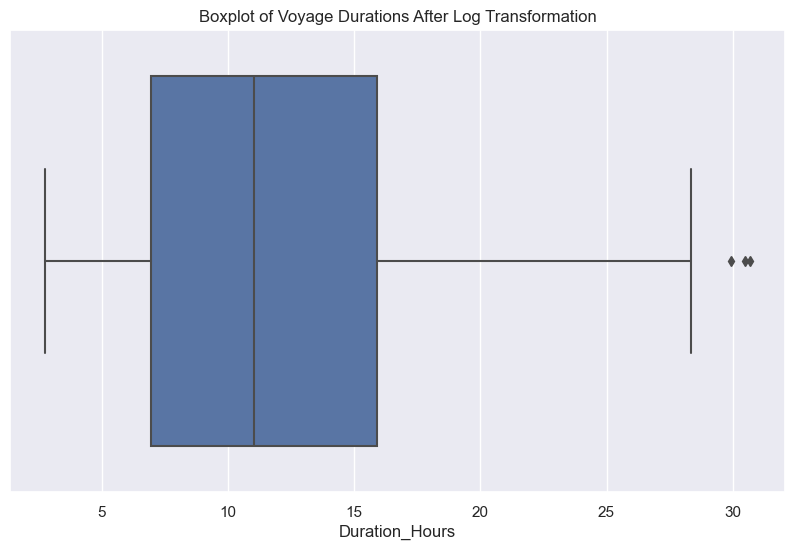

In [301]:
# Calculating time difference between the first and last BaseDateTime
def calculate_time_difference_per_voyage(df):
    time_differences = []
    
    for voyage_id, voyage_group in df.groupby('ShipVoyage'):
        voyage_group['BaseDateTime'] = pd.to_datetime(voyage_group['BaseDateTime'])
        first_time = voyage_group['BaseDateTime'].min()
        last_time = voyage_group['BaseDateTime'].max()
        time_diff_hours = (last_time - first_time).total_seconds() / 3600  # Return difference in hours
        time_differences.append((voyage_id, time_diff_hours))
    
    return pd.DataFrame(time_differences, columns=['Voyage_File', 'Duration_Hours'])

# Detecting outliers using IQR
def detect_outliers_iqr(time_differences):
    Q1 = time_differences['Duration_Hours'].quantile(0.25)
    Q3 = time_differences['Duration_Hours'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return time_differences[(time_differences['Duration_Hours'] < lower_bound) | (time_differences['Duration_Hours'] > upper_bound)]

# Applying log transformation to specific voyages
def apply_log_transformation(df, voyage_ids):
    for voyage_id in voyage_ids:
        index = df[df['Voyage_File'] == voyage_id].index
        
        if not index.empty:
            # Applying log transformation (use log1p to avoid issues with zero or negative values)
            df.loc[index, 'Duration_Hours'] = np.log1p(df.loc[index, 'Duration_Hours'])
            print(f"Applied log transformation to {voyage_id}.")
        else:
            print(f"Voyage {voyage_id} not found in the dataset.")
    
    return df

# Calculating the time differences for each ShipVoyage in dfToEDA
voyage_df = calculate_time_difference_per_voyage(dfToEDA)

# Detecting outliers using IQR
outliers = detect_outliers_iqr(voyage_df)

print("Outliers based on voyage durations:")
outlier_df = voyage_df[voyage_df['Duration_Hours'].isin(outliers['Duration_Hours'])]
print(outlier_df)

# Applying log transformation to the specific outliers
outlier_voyages = ['255792000_0', '636022103_2']
voyage_df_transformed = apply_log_transformation(voyage_df, outlier_voyages)

print(voyage_df_transformed[voyage_df_transformed['Voyage_File'].isin(outlier_voyages)])

# Plot after log transformation (boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(x=voyage_df_transformed['Duration_Hours'])
plt.title('Boxplot of Voyage Durations After Log Transformation')
plt.show()




### Displaying a map with first and last registered points

In [167]:
# Center coordinates for the map (Sines port)
Sines_coords = [37.933896, -8.855063]

# Create a map centered on the port
m = fl.Map(location=Sines_coords, zoom_start=11)

# Add a 50 km circle and a 3 km circle around the port
fl.Circle(location=Sines_coords, radius=50000, color='blue', fill=True, fill_opacity=0.1).add_to(m)
fl.Circle(location=Sines_coords, radius=7000, color='red', fill=True, fill_opacity=0.3).add_to(m)

# Filter the DataFrame for rows where SOG is ≤ 1
moored_points_df = dfToEDA.loc[dfToEDA["SOG"] <= 1.0, ["LAT", "LON", "ShipVoyage"]]

# Initialize an empty DataFrame to store the first and last moored points per ShipVoyage
first_last_moored_points = pd.DataFrame()

# Group by 'ShipVoyage' and get the first and last moored points for each voyage
for voyage_id, group in moored_points_df.groupby("ShipVoyage"):
    if not group.empty:
        first_last_points = pd.concat([group.iloc[[0]], group.iloc[[-1]]])  # First and last point of each voyage
        first_last_moored_points = pd.concat([first_last_moored_points, first_last_points])

# Add a FastMarkerCluster for the first and last moored points
fmc = FastMarkerCluster(data=first_last_moored_points[['LAT', 'LON']].values.tolist())
fmc.add_to(m)

# Save the map as an HTML file
m.save(Map_html)

print(f"Map with first and last moored points saved at: {Map_html}")

Map with first and last moored points saved at: D:\A TESE\Modelo ML\Sines_map.html


### Histogram of Voyage Durations

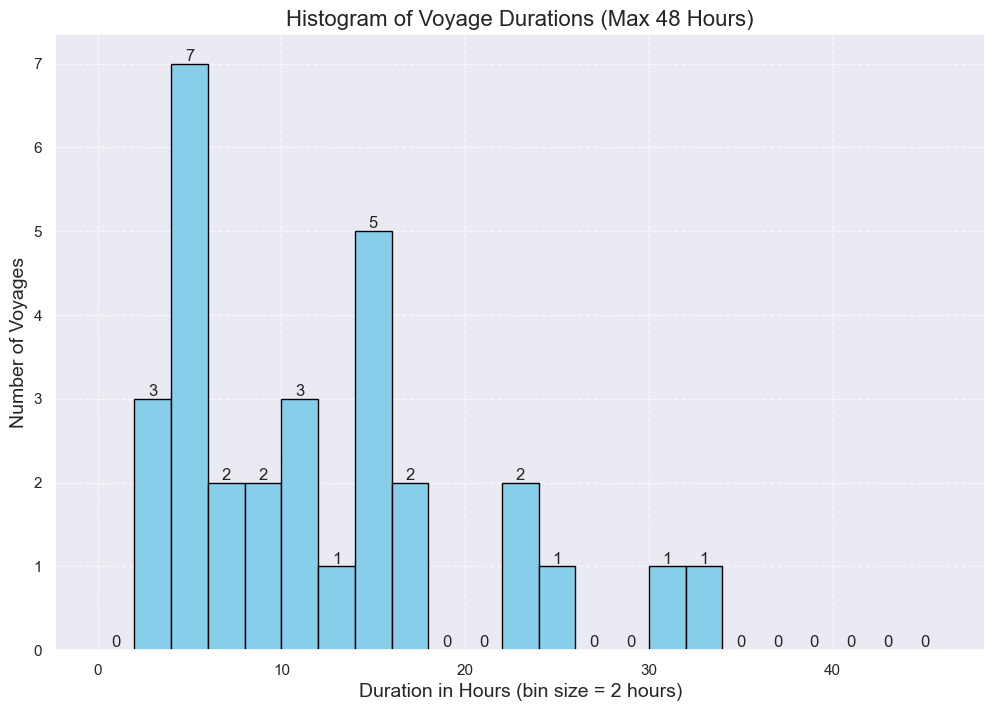

In [162]:
# Histogram of voyage durations

voyage_durations = dfToEDA.groupby('Imo')['BaseDateTime'].agg([min, max])
voyage_durations['Duration Hours'] = (voyage_durations['max'] - voyage_durations['min']).dt.total_seconds() / 3600

# Filter voyages to be at most 60 hours for better visualization
voyage_durations = voyage_durations[voyage_durations['Duration Hours'] <= 48]

# Plotting the histogram of voyage durations (Max 60 Hours)
# plt.figure(figsize=(12, 8))
n, bins, patches = plt.hist(voyage_durations['Duration Hours'], bins=range(0, 48, 2), color='skyblue', edgecolor='black')

# Add data labels on top of the bars
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width() / 2, patches[i].get_height(), str(int(n[i])), ha='center', va='bottom')

# Customize the plot
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Histogram of Voyage Durations (Max 48 Hours)', fontsize=16)
plt.xlabel('Duration in Hours (bin size = 2 hours)', fontsize=14)
plt.ylabel('Number of Voyages', fontsize=14)
plt.show()

### Correlation heatmap

In [313]:
# Checking for missing values in dfToEDA per ShipVoyage
missing_values_per_voyage = dfToEDA.groupby('ShipVoyage').apply(lambda x: x.isnull().sum())
print(missing_values_per_voyage)

             BaseDateTime  LON  LAT  MMSI  Imo  Type  ETA  Destination  SOG  \
ShipVoyage                                                                    
209550000_0             0    0    0     0    0     0    0            0    0   
209720000_0             0    0    0     0    0     0    0            0    0   
209917000_0             0    0    0     0    0     0    0            0    0   
236111906_1             0    0    0     0    0     0    0            0    0   
236111906_3             0    0    0     0    0     0    0            0    0   
...                   ...  ...  ...   ...  ...   ...  ...          ...  ...   
636022920_0             0    0    0     0    0     0    0            0    0   
636022920_1             0    0    0     0    0     0    0            0    0   
636022920_2             0    0    0     0    0     0    0            0    0   
636023185_0             0    0    0     0    0     0    0            0    0   
636023479_0             0    0    0     0    0     0

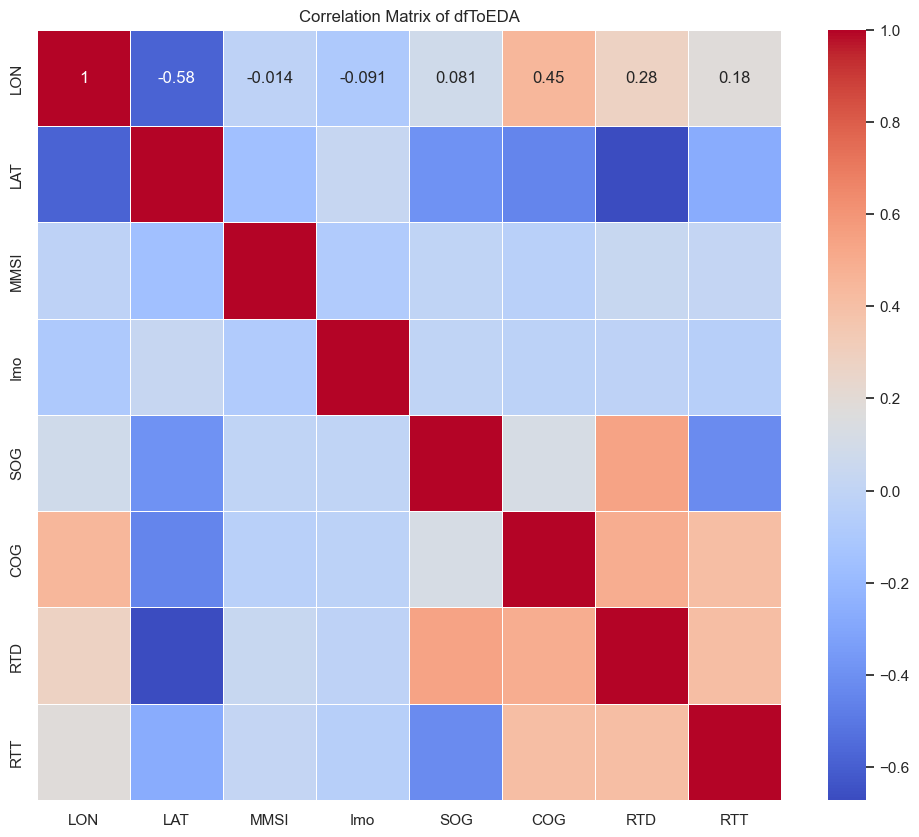

Original number of ShipVoyage: 75
Number of ShipVoyage after cleaning: 75


In [385]:
dfToEDA_clean = dfToEDA.copy()

ship_voyage_column = dfToEDA_clean['ShipVoyage']

# Dropping the 'Type' column and selecting only numeric columns for Correlation Analysis
dfToEDA_clean = dfToEDA_clean.drop(columns=['Type'])
numeric_data = dfToEDA_clean.select_dtypes(include=["number"])

# Performing Correlation Analysis
correlation_matrix = numeric_data.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of dfToEDA')
plt.show()

# Saving the correlation matrix to CSV
correlation_matrix.to_csv('D:/A TESE/Modelo ML/CSV/corr_matrix.csv', index=True)

# Adding back the 'ShipVoyage' column to the cleaned DataFrame if needed later
dfToEDA_clean['ShipVoyage'] = ship_voyage_column

# Keep the ShipVoyage column intact
print(f"Original number of ShipVoyage: {dfToEDA['ShipVoyage'].nunique()}")
print(f"Number of ShipVoyage after cleaning: {dfToEDA_clean['ShipVoyage'].nunique()}")


#### Dropping low-correlated features (to RTT)

In [387]:
# Dropping irrelevant features for RTT prediction
irrelevant_features = ['Imo', 'MMSI', 'ETA', 'Destination']  # List of features to drop
dfToEDA_clean = dfToEDA_clean.drop(columns=irrelevant_features)

In [389]:
dfToEDA_clean.head()

,BaseDateTime,LON,LAT,SOG,COG,ShipVoyage,RTD,RTT
0,2023-09-25 12:49:00,-7.689917,36.357050,16.8,288.0,209550000_0,203.485182,6.540072
1,2023-09-25 12:49:02,-7.690650,36.357233,16.8,288.0,209550000_0,203.434578,6.538445
2,2023-09-25 12:49:14,-7.691667,36.357500,16.8,288.0,209550000_0,203.363237,6.536153
3,2023-09-25 12:49:20,-7.692200,36.357650,16.8,288.0,209550000_0,203.324848,6.534919
4,2023-09-25 12:49:32,-7.693300,36.357950,16.8,288.0,209550000_0,203.246588,6.532403


#### Checking multicollinearity with VIF

In [391]:
# Selecting the features for multicollinearity check
features_to_check = ['LON', 'LAT','SOG', 'COG', 'RTD']
df_subset = dfToEDA_clean[features_to_check].apply(pd.to_numeric, errors='coerce')

vif_data = pd.DataFrame()
vif_data["Feature"] = df_subset.columns
vif_data["VIF"] = [variance_inflation_factor(df_subset.values, i) for i in range(len(df_subset.columns))]
print(vif_data)

  Feature         VIF
0     LON  233.612099
1     LAT  253.427063
2     SOG    5.694636
3     COG    4.543121
4     RTD    4.213452


#### Checking distribution

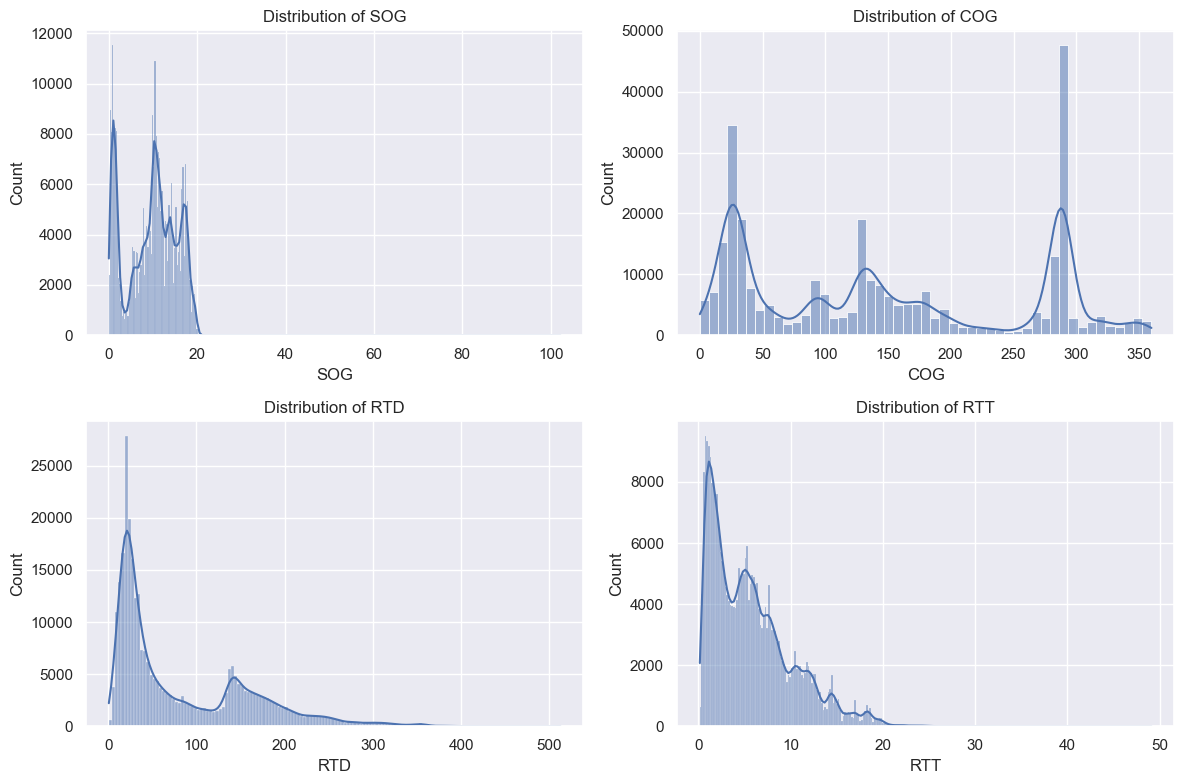

In [393]:
# Features to check
features_check = ['SOG', 'COG', 'RTD', 'RTT']

for i, feature in enumerate(features_check, 1):
    plt.subplot(2, 2, i)
    sns.histplot(dfToEDA_clean[feature], kde=True)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

In [ ]:
# Next step is saving the datasets

#### Feature scaling

In [349]:
# NOT USED

# Features to scale
features_to_scale = ['SOG', 'COG', 'RTD']

scaled_features = pd.DataFrame()
scaler = StandardScaler()
scaled_features[features_to_scale] = scaler.fit_transform(dfToEDA_clean[features_to_scale])

print(scaled_features.head())

        SOG      COG       RTD
0  1.262534  1.28688  1.551879
1  1.262534  1.28688  1.551224
2  1.262534  1.28688  1.550302
3  1.262534  1.28688  1.549806
4  1.262534  1.28688  1.548795


#### Checking distribution after scaling

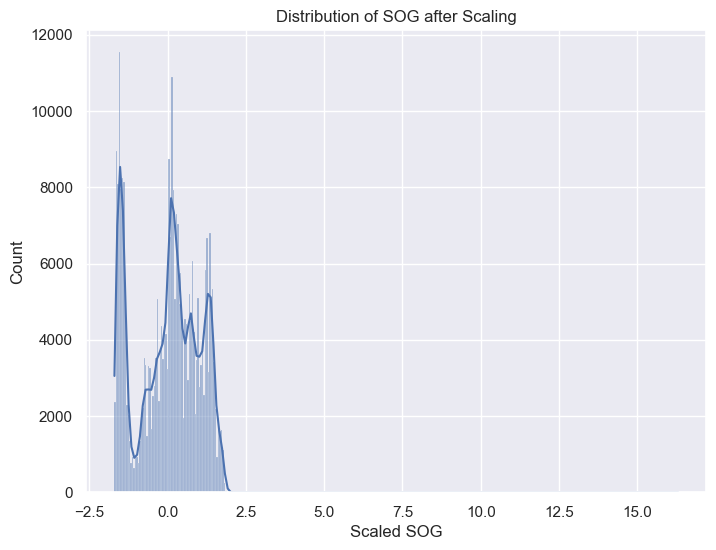

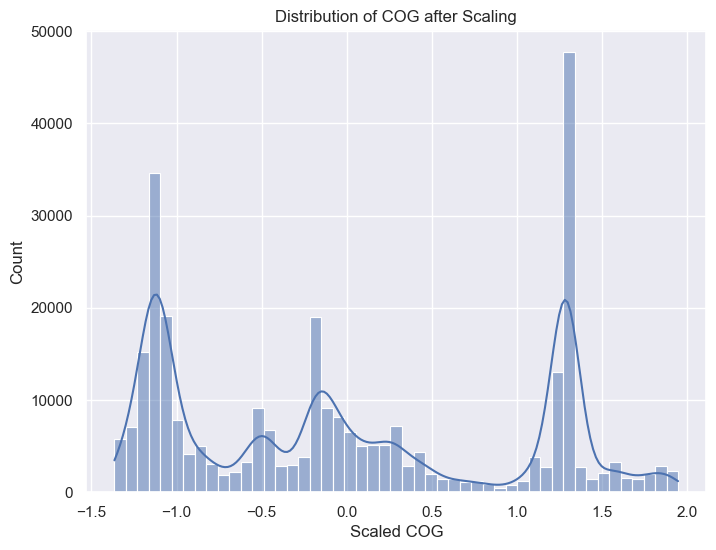

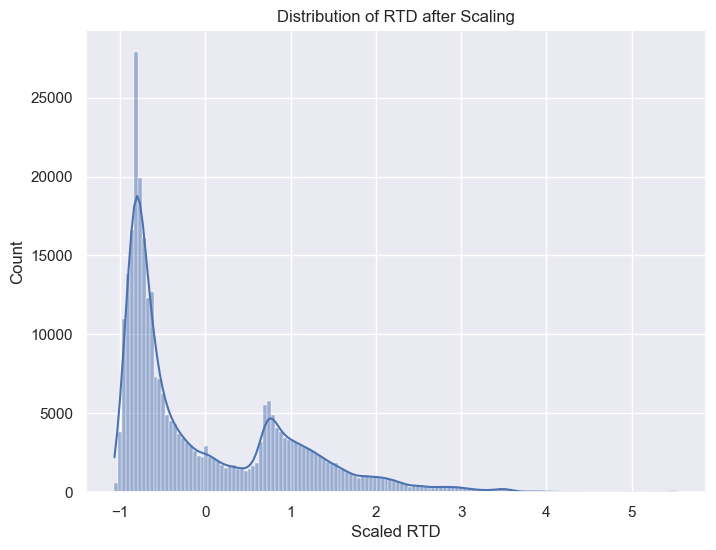

In [262]:
# NOT USED

for feature in features_to_scale:
    plt.figure(figsize=(8, 6))
    sns.histplot(scaled_features[feature], kde=True)
    plt.title(f'Distribution of {feature} after Scaling')
    plt.xlabel(f'Scaled {feature}')
    plt.ylabel('Count')
    plt.show()


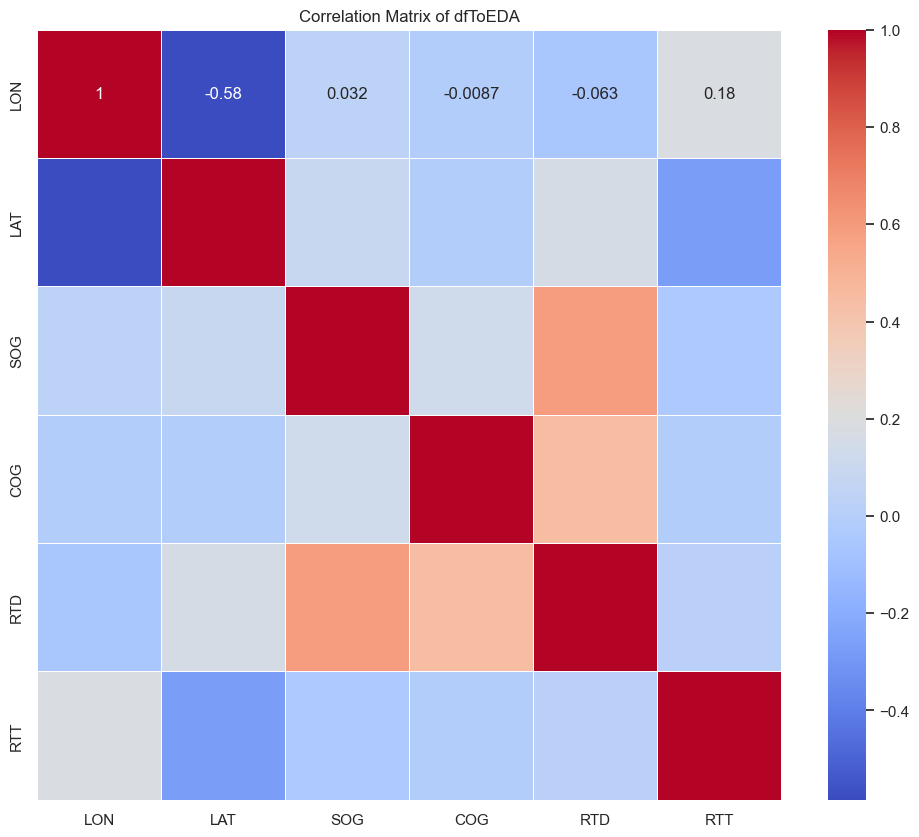

In [383]:
numeric_data = dfToEDA_clean.select_dtypes(include=["number"])

# Performing Correlation Analysis
correlation_matrix = numeric_data.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of dfToEDA')
plt.show()

# Saving the correlation matrix to CSV
correlation_matrix.to_csv('D:/A TESE/Modelo ML/CSV/corr_matrix_2.csv', index=True)

# Adding back the 'ShipVoyage' column to the cleaned DataFrame if needed later
dfToEDA_clean['ShipVoyage'] = ship_voyage_column


In [396]:
# Loop through each ShipVoyage group and save as separate CSV files
for ship_voyage, group in dfToEDA_clean.groupby('ShipVoyage'):
    file_path = os.path.join(Voyages_final, f"{ship_voyage}.csv")
    group.to_csv(file_path, index=False)

print(f"Final datasets have been saved in {Voyages_final}.")

Final datasets have been saved in D:\A TESE\Modelo ML\CSV\voyages_final.


In [398]:
# Verifying the number of CSV files
csv_files = [f for f in os.listdir(Voyages_final) if f.endswith('.csv')]
csv_count = len(csv_files)

print(f"Total CSV files created: {csv_count}")

Total CSV files created: 75
